# Assignment 1
**Credits**: Federico Ruggeri, Eleonora Mancini, Paolo Torroni

**Keywords**: Sexism Detection, Multi-class Classification, RNNs, Transformers, Huggingface



# Contact
For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

- Federico Ruggeri -> federico.ruggeri6@unibo.it
- Eleonora Mancini -> e.mancini@unibo.it

Professor:
- Paolo Torroni -> p.torroni@unibo.it

# Introduction
You are asked to address the [EXIST 2023 Task 1](https://clef2023.clef-initiative.eu/index.php?page=Pages/labs.html#EXIST) on sexism detection.

## Problem Definition
The systems have to decide whether or not a given tweet contains or describes sexist expressions or behaviors (i.e., it is sexist itself, describes a sexist situation or criticizes a sexist behavior).

### Examples:

**Text**: *Can’t go a day without women womening*

**Label**: Sexist

**Text**: *''Society's set norms! Happy men's day though!#weareequal''*

**Label**: Not sexist

#[Task 1 - 1.0 points] Corpus

We have preparared a small version of EXIST dataset in our dedicated [Github repository](https://github.com/lt-nlp-lab-unibo/nlp-course-material/tree/main/2024-2025/Assignment%201/data).

Check the `A1/data` folder. It contains 3 `.json` files representing `training`, `validation` and `test` sets.

The three sets are slightly unbalanced, with a bias toward the `Non-sexist` class.



### Dataset Description
- The dataset contains tweets in both English and Spanish.
- There are labels for multiple tasks, but we are focusing on **Task 1**.
- For Task 1, soft labels are assigned by six annotators.
- The labels for Task 1 represent whether the tweet is sexist ("YES") or not ("NO").







### Example


    "203260": {
        "id_EXIST": "203260",
        "lang": "en",
        "tweet": "ik when mandy says “you look like a whore” i look cute as FUCK",
        "number_annotators": 6,
        "annotators": ["Annotator_473", "Annotator_474", "Annotator_475", "Annotator_476", "Annotator_477", "Annotator_27"],
        "gender_annotators": ["F", "F", "M", "M", "M", "F"],
        "age_annotators": ["18-22", "23-45", "18-22", "23-45", "46+", "46+"],
        "labels_task1": ["YES", "YES", "YES", "NO", "YES", "YES"],
        "labels_task2": ["DIRECT", "DIRECT", "REPORTED", "-", "JUDGEMENTAL", "REPORTED"],
        "labels_task3": [
          ["STEREOTYPING-DOMINANCE"],
          ["OBJECTIFICATION"],
          ["SEXUAL-VIOLENCE"],
          ["-"],
          ["STEREOTYPING-DOMINANCE", "OBJECTIFICATION"],
          ["OBJECTIFICATION"]
        ],
        "split": "TRAIN_EN"
      }
    }

### Instructions
1. **Download** the `A1/data` folder.
2. **Load** the three JSON files and encode them as pandas dataframes.
3. **Generate hard labels** for Task 1 using majority voting and store them in a new dataframe column called `hard_label_task1`. Items without a clear majority will be removed from the dataset.
4. **Filter the DataFrame** to keep only rows where the `lang` column is `'en'`.
5. **Remove unwanted columns**: Keep only `id_EXIST`, `lang`, `tweet`, and `hard_label_task1`.
6. **Encode the `hard_label_task1` column**: Use 1 to represent "YES" and 0 to represent "NO".

In [1]:
import os
import requests
from pathlib import Path
import pandas as pd
import json
import zipfile
import numpy as np
from tqdm import tqdm  # for progress bar
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import precision_score, recall_score, f1_score
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# Define the GitHub base URL for raw files (replace <username>, <repository>, <branch>, and <path>)
base_url = "https://raw.githubusercontent.com/nlp-unibo/nlp-course-material/refs/heads/main/2024-2025/Assignment%201/data/"

# List of JSON file names in the A1/data directory
json_files = ["test.json", "training.json", "validation.json"]

# Local directory to save the files
local_dir = Path("Assignment%201/data")
local_dir.mkdir(parents=True, exist_ok=True)


# Download each file
for file_name in json_files:
    url = base_url + file_name
    response = requests.get(url)

    if response.status_code == 200:
        with open(local_dir / file_name, "wb") as file:
            file.write(response.content)
        print(f"Downloaded {file_name}")
    else:
        print(f"Failed to download {file_name}")


# Load JSON files into pandas DataFrames
dataframes = {}
for file_name in json_files:
    with open(local_dir / file_name, "r") as file:
        data = json.load(file)
        dataframes[file_name] = pd.DataFrame(data)


original_train_df = dataframes['training.json']
original_validation_df = dataframes['validation.json']
original_test_df = dataframes['test.json']

Downloaded test.json
Downloaded training.json
Downloaded validation.json


In [3]:
def determine_majority(response_list):
    yes_count = response_list.count("YES")
    no_count = response_list.count("NO")

    if yes_count > no_count:
        return 1
    elif no_count > yes_count:
        return 0
    else:
        return 2


def transform_df(df):
    # Swap row and col
    df = df.T
    # Apply majority voting to task 1
    df['hard_label_task1'] = df['labels_task1'].apply(determine_majority)
    # Keep only row that has en as lang and does not have a draw in voting
    df = df[df['lang'] == 'en']
    df = df[df['hard_label_task1'] != 2]
    # Drop unecessary columns
    df = df[['id_EXIST', 'lang', 'tweet', 'hard_label_task1']]

    return df


In [4]:
original_train_df = transform_df(original_train_df)
original_validation_df = transform_df(original_validation_df)
original_test_df = transform_df(original_test_df)
original_train_df

,id_EXIST,lang,tweet,hard_label_task1
200002,200002,en,Writing a uni essay in my local pub with a cof...,1
200003,200003,en,@UniversalORL it is 2021 not 1921. I dont appr...,1
200006,200006,en,According to a customer I have plenty of time ...,1
200007,200007,en,"So only 'blokes' drink beer? Sorry, but if you...",1
200008,200008,en,New to the shelves this week - looking forward...,0
...,...,...,...,...
203256,203256,en,idk why y’all bitches think having half your a...,1
203257,203257,en,This has been a part of an experiment with @Wo...,1
203258,203258,en,"""Take me already"" ""Not yet. You gotta be ready...",1
203259,203259,en,@clintneedcoffee why do you look like a whore?...,1


# [Task2 - 0.5 points] Data Cleaning
In the context of tweets, we have noisy and informal data that often includes unnecessary elements like emojis, hashtags, mentions, and URLs. These elements may interfere with the text analysis.



### Instructions
- **Remove emojis** from the tweets.
- **Remove hashtags** (e.g., `#example`).
- **Remove mentions** such as `@user`.
- **Remove URLs** from the tweets.
- **Remove special characters and symbols**.
- **Remove specific quote characters** (e.g., curly quotes).
- **Perform lemmatization** to reduce words to their base form.

In [5]:
train_df = original_train_df.copy()
validation_df = original_validation_df.copy()
test_df = original_test_df.copy()

In [6]:
# Download NLTK resources (only need to run this once)
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')

# Create the lemmatizer
lemmatizer = WordNetLemmatizer()


# Function to clean tweets
def clean_tweet(tweet):
    # Remove emojis using a regex
    tweet = re.sub(r'[^\x00-\x7F]+', '', tweet)
    # Remove hashtags (e.g., #example)
    tweet = re.sub(r'#\w+', '', tweet)
    # Remove mentions (e.g., @user)
    tweet = re.sub(r'@\w+', '', tweet)
    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+', '', tweet)
    # Remove special characters and symbols
    tweet = re.sub(r'[^a-zA-Z0-9\s]', '', tweet)
    # Remove specific quote characters (curly quotes, etc.)
    tweet = tweet.replace('“', '').replace('”', '').replace('‘', '').replace('’', '')
    # Convert to lowercase
    tweet = tweet.lower()
    # Tokenize the tweet
    words = word_tokenize(tweet)
    # Lemmatize the words and remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

    # Rejoin words into a cleaned-up tweet
    cleaned_tweet = ' '.join(words)

    return cleaned_tweet


# Apply the cleaning function to the 'tweet' column
train_df['tweet'] = train_df['tweet'].apply(clean_tweet)
validation_df['tweet'] = validation_df['tweet'].apply(clean_tweet)
test_df['tweet'] = test_df['tweet'].apply(clean_tweet)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
train_df

,id_EXIST,lang,tweet,hard_label_task1
200002,200002,en,writing uni essay local pub coffee random old ...,1
200003,200003,en,2021 1921 dont appreciate two ride team member...,1
200006,200006,en,according customer plenty time go spent stirli...,1
200007,200007,en,bloke drink beer sorry arent bloke drink wine ...,1
200008,200008,en,new shelf week looking forward reading book,0
...,...,...,...,...
203256,203256,en,idk yall bitch think half as hanging cute look...,1
203257,203257,en,part experiment im learning though there littl...,1
203258,203258,en,take already yet got ta readyim dripping say d...,1
203259,203259,en,look like whore lh,1


# [Task 3 - 0.5 points] Text Encoding
To train a neural sexism classifier, you first need to encode text into numerical format.




### Instructions

* Embed words using **GloVe embeddings**.
* You are **free** to pick any embedding dimension.





### Note : What about OOV tokens?
   * All the tokens in the **training** set that are not in GloVe **must** be added to the vocabulary.
   * For the remaining tokens (i.e., OOV in the validation and test sets), you have to assign them a **special token** (e.g., [UNK]) and a **static** embedding.
   * You are **free** to define the static embedding using any strategy (e.g., random, neighbourhood, etc...)



### More about OOV

For a given token:

* **If in train set**: add to vocabulary and assign an embedding (use GloVe if token in GloVe, custom embedding otherwise).
* **If in val/test set**: assign special token if not in vocabulary and assign custom embedding.

Your vocabulary **should**:

* Contain all tokens in train set; or
* Union of tokens in train set and in GloVe $\rightarrow$ we make use of existing knowledge!

In [8]:
# Function to download GloVe embeddings with a progress bar
def download_glove_embeddings(glove_url, save_path='glove.zip', extract_path='glove'):
    if not os.path.exists(extract_path):  # Only download if not already downloaded
        print("Downloading GloVe embeddings...")

        # Stream the download with a progress bar
        response = requests.get(glove_url, stream=True)
        total_size = int(response.headers.get('content-length', 0))

        with open(save_path, 'wb') as f, tqdm(
            desc="Downloading",
            total=total_size,
            unit='B',
            unit_scale=True,
            unit_divisor=1024,
        ) as bar:
            for data in response.iter_content(chunk_size=1024):
                f.write(data)
                bar.update(len(data))

        # Extract the zip file
        print("Extracting GloVe embeddings...")
        with zipfile.ZipFile(save_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)

        # Clean up by removing the zip file
        os.remove(save_path)
        print("Download and extraction complete.")
    else:
        print("GloVe embeddings already downloaded.")


# Load the GloVe embeddings from the extracted file
def load_glove_embeddings(filepath, embedding_dim=100):
    embeddings = {}
    with open(filepath, 'r', encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings


# Define the GloVe URL and download path
glove_url = "http://nlp.stanford.edu/data/glove.6B.zip"  # 6B is the 400K word vocab, various embedding dim
download_path = 'glove.6B.zip'
extract_path = 'glove'

# Download and extract GloVe embeddings
download_glove_embeddings(glove_url, download_path, extract_path)

# Specify the embedding dimension and file, choose dim from 50,100,200,300
embedding_dim = 100
glove_filepath = os.path.join(extract_path, f'glove.6B.{embedding_dim}d.txt')

# Load embeddings
glove_embeddings = load_glove_embeddings(glove_filepath, embedding_dim)
print("Loaded GloVe embeddings with dimension:", embedding_dim)


Downloading: 100%|██████████| 822M/822M [02:40<00:00, 5.37MB/s]


Extracting GloVe embeddings...
Download and extraction complete.
Loaded GloVe embeddings with dimension: 100


In [9]:
def find_series_max_len(series_list):
    # Concatenate all Series into a single Series
    all_text = pd.concat(series_list, ignore_index=True)
    word_count = all_text.apply(lambda x: len(str(x).split()))
    max_word_count = word_count.max()
    return max_word_count


def pad_text_column(df, column_name, max_len, pad_token="<PAD>"):
    # Apply padding
    df['padded_' + column_name] = df[column_name].apply(lambda x: x if isinstance(x, list) else x.split())  # Tokenize if not already
    df['padded_' + column_name] = df['padded_' + column_name].apply(
        lambda x: x[:max_len] + [pad_token] * (max_len - len(x)) if len(x) < max_len else x[:max_len]
    )

    return df

MAX_LEN = find_series_max_len([train_df['tweet'], validation_df['tweet'], test_df['tweet']])
print(f"Max lenght found: {MAX_LEN}")

train_df = pad_text_column(train_df, 'tweet', MAX_LEN)
validation_df = pad_text_column(validation_df, 'tweet', MAX_LEN)
test_df = pad_text_column(test_df, 'tweet', MAX_LEN)

print(train_df['padded_tweet'].iloc[0])

Max lenght found: 36
['writing', 'uni', 'essay', 'local', 'pub', 'coffee', 'random', 'old', 'man', 'keep', 'asking', 'drunk', 'question', 'im', 'trying', 'concentrate', 'amp', 'end', 'good', 'luck', 'youll', 'end', 'getting', 'married', 'use', 'anyway', 'alive', 'well', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


In [10]:
# Tokenize tweets and build vocabulary
def build_vocab_and_embeddings(data, embeddings_index, embedding_dim):
    vocab = {}
    word_embeddings = []
    for tweet in data['padded_tweet']:
        for token in tweet:
            if token not in vocab:
                if token in embeddings_index:
                    # Use GloVe embedding
                    vocab[token] = len(vocab)
                    word_embeddings.append(embeddings_index[token])
                else:
                    # Generate a random embedding for OOV tokens in the training set
                    vocab[token] = len(vocab)
                    word_embeddings.append(np.random.uniform(-0.1, 0.1, embedding_dim))
    return vocab, word_embeddings

# Build vocabulary and embeddings for the training set
vocab, word_embeddings = build_vocab_and_embeddings(train_df, glove_embeddings, embedding_dim)

In [11]:
unk_token = '[UNK]'
vocab[unk_token] = len(vocab)

# Custom embedding for '[UNK]', mean of GloVe embeddings
unk_embedding = np.mean(word_embeddings, axis=0)
word_embeddings = np.vstack([word_embeddings, unk_embedding])

In [12]:
# Apply the embeddings to the given df
def embed_tweet(df, vocab, word_embeddings):
    data = df.copy()
    new_tweet = []
    for tweet in data['padded_tweet']:
        embedded_tweet = []
        for token in tweet:
            if token not in vocab:
                # token is OOV so considered UNK
                embedded_tweet.append(word_embeddings[vocab['[UNK]']])
            else:
                embedded_tweet.append(word_embeddings[vocab[token]])
        new_tweet.append(embedded_tweet)
    data['padded_tweet'] = new_tweet
    return data

# Embed all the df with our extended GloVe embeddings
train_df_embedded = embed_tweet(train_df, vocab, word_embeddings)
validation_df_embedded = embed_tweet(validation_df, vocab, word_embeddings)
test_df_embedded = embed_tweet(test_df, vocab, word_embeddings)
train_df_embedded.head()

,id_EXIST,lang,tweet,hard_label_task1,padded_tweet
200002,200002,en,writing uni essay local pub coffee random old ...,1,"[[0.17459000647068024, 0.2806999981403351, -0...."
200003,200003,en,2021 1921 dont appreciate two ride team member...,1,"[[0.4375700056552887, 0.5958300232887268, 0.52..."
200006,200006,en,according customer plenty time go spent stirli...,1,"[[-0.06825800240039825, -0.04764899984002113, ..."
200007,200007,en,bloke drink beer sorry arent bloke drink wine ...,1,"[[0.1125900000333786, 0.4171999990940094, 0.62..."
200008,200008,en,new shelf week looking forward reading book,0,"[[-0.04395899921655655, 0.18935999274253845, 0..."


# [Task 4 - 1.0 points] Model definition

You are now tasked to define your sexism classifier.




### Instructions

* **Baseline**: implement a Bidirectional LSTM with a Dense layer on top.
* You are **free** to experiment with hyper-parameters to define the baseline model.

* **Model 1**: add an additional LSTM layer to the Baseline model.

### Token to embedding mapping

You can follow two approaches for encoding tokens in your classifier.

### Work directly with embeddings

- Compute the embedding of each input token
- Feed the mini-batches of shape (batch_size, # tokens, embedding_dim) to your model

### Work with Embedding layer

- Encode input tokens to token ids
- Define a Embedding layer as the first layer of your model
- Compute the embedding matrix of all known tokens (i.e., tokens in your vocabulary)
- Initialize the Embedding layer with the computed embedding matrix
- You are **free** to set the Embedding layer trainable or not

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, bidirectional=True):
        super(BiLSTMModel, self).__init__()

        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            bidirectional=bidirectional,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, output_size)

    def forward(self, x):
        lstm_out, (hidden, cell) = self.lstm(x)  # lstm_out has shape [batch, seq_len, hidden_size * 2] if bidirectional

        # Take the last hidden state from both directions (forward and backward) for the last timestep
        if self.lstm.bidirectional:
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)  # Concatenate the last forward and backward hidden states
        else:
            hidden = hidden[-1,:,:]  # Take the last hidden state of the forward direction only

        out = self.fc(hidden)
        return out.view(-1)

In [14]:
input_size = 100
hidden_size = 128
num_layers = 1
output_size = 1

baseline_model = BiLSTMModel(input_size, hidden_size, num_layers, output_size)

In [15]:
num_layers = 2

model_1 = BiLSTMModel(input_size, hidden_size, num_layers, output_size)

### Padding

Pay attention to padding tokens!

Your model **should not** be penalized on those tokens.

#### How to?

There are two main ways.

However, their implementation depends on the neural library you are using.

- Embedding layer
- Custom loss to compute average cross-entropy on non-padding tokens only

**Note**: This is a **recommendation**, but we **do not penalize** for missing workarounds.

# [Task 5 - 1.0 points] Training and Evaluation

You are now tasked to train and evaluate the Baseline and Model 1.



### Instructions

* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Compute metrics on the validation set.
* Pick **at least** three seeds for robust estimation.
* Pick the **best** performing model according to the observed validation set performance.
* Evaluate your models using macro F1-score.

In [72]:
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy

class CustomTrainer:
    def __init__(self, model, output_size=5, learning_rate=0.001, num_epochs=20, batch_size=32, seed=42):
        self.set_seed(seed)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}", end='\n\n')

        self.model = model.to(self.device)
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.criterion = nn.BCEWithLogitsLoss()
        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    def set_seed(self, seed):
        """Set the seed for reproducibility."""
        random.seed(seed)  # Python random module
        np.random.seed(seed)  # NumPy random module
        torch.manual_seed(seed)  # PyTorch CPU
        torch.cuda.manual_seed(seed)  # PyTorch GPU (if CUDA is available)
        torch.cuda.manual_seed_all(seed)  # PyTorch all GPUs (if using multiple GPUs)
        torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior
        torch.backends.cudnn.benchmark = False  # Disable the auto-tuner to avoid randomness
        self.seed = seed


    def train(self, train_df):
        # Prepare training data
        self.x_train = torch.tensor(train_df['padded_tweet'], dtype=torch.float32).to(self.device)
        self.y_train = torch.tensor(train_df['hard_label_task1'], dtype=torch.float32).to(self.device)
        self.train_dataset = TensorDataset(self.x_train, self.y_train)
        self.train_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

        # Training loop
        losses = []
        for epoch in tqdm(range(self.num_epochs), desc=f'Training with seed {self.seed}'):
            self.model.train()  # Set the model to training mode
            running_loss = 0.0  # Track the total loss for the epoch

            for batch_idx, (inputs, labels) in enumerate(self.train_loader):
                # Zero the parameter gradients
                self.optimizer.zero_grad()

                # Forward pass
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)

                # Backward pass and optimization
                loss.backward()
                self.optimizer.step()

                # Accumulate the loss
                running_loss += loss.item()

            # Print the average loss for this epoch
            avg_loss = running_loss / len(self.train_loader)
            losses.append(avg_loss)
            #(f"Epoch [{epoch + 1}/{self.num_epochs}], Loss: {avg_loss:.4f}")
        return losses

    def test(self, test_df):
        # Prepare test data
        x_test = torch.tensor(test_df['padded_tweet'], dtype=torch.float32).to(self.device)
        y_test = torch.tensor(test_df['hard_label_task1'], dtype=torch.float32).to(self.device)
        test_dataset = TensorDataset(x_test, y_test)
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)

        # Set the model to evaluation mode
        self.model.eval()

        all_preds = []
        all_labels = []

        with torch.no_grad():  # No need to compute gradients during evaluation
            for inputs, labels in test_loader:
                # Forward pass
                outputs = self.model(inputs)

                # Apply sigmoid activation to outputs, since BCEWithLogitsLoss already includes sigmoid
                predicted = torch.round(torch.sigmoid(outputs))  # Convert outputs to binary predictions

                all_preds.append(predicted.cpu().numpy())
                all_labels.append(labels.cpu().numpy())

        # Flatten the lists
        all_preds = np.concatenate(all_preds, axis=0)
        all_labels = np.concatenate(all_labels, axis=0)

        # Calculate precision, recall, and F1 score
        precision = precision_score(all_labels, all_preds, average='macro')
        recall = recall_score(all_labels, all_preds, average='macro')
        f1 = f1_score(all_labels, all_preds, average='macro')

        accuracy = (all_preds == all_labels).mean()

        return accuracy, f1


    def train_and_evaluate_multiple_seeds(self, train_df, test_df, num_seeds=5):
        all_losses = []
        all_accuracies = []
        # Save the untrained model temporay
        untrained_model = copy.deepcopy(self.model.state_dict())  # Save a deep copy of the initial weights

        print(f"### Start training and testing with {num_seeds} seeds ###")
        # Loop through multiple seeds
        for seed in range(num_seeds):
            self.set_seed(seed)  # Set the seed for reproducibility

            # Train and evaluate the model
            epoch_losses = self.train(train_df)
            accuracy, f1 = self.test(test_df)

            # Reset the model to untrained version so that with next seed will start train from scratch
            self.model.load_state_dict(untrained_model)

            print(f"Accuracy on val: {accuracy:.4f}, f1-score on val: {f1:.4f}", end="\n\n")
            all_losses.append(epoch_losses)
            all_accuracies.append(accuracy)

        # Convert lists to numpy arrays for easier manipulation
        all_losses = np.array(all_losses)
        all_accuracies = np.array(all_accuracies)

        # Plot the learning curves: max, min, avg loss across all seeds
        self.plot_learning_curve(all_losses, all_accuracies)


    def plot_learning_curve(self, all_losses, all_accuracies):
        # Plot loss curves (min, max, avg)
        plt.figure(figsize=(12, 6))

        # Plot loss
        plt.subplot(1, 2, 1)
        plt.plot(all_losses.mean(axis=0), label='Avg Loss', color='blue')
        plt.fill_between(range(len(all_losses[0])), all_losses.min(axis=0), all_losses.max(axis=0), color='blue', alpha=0.2)
        plt.title('Learning Curve (Loss)')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()

Using device: cuda

### Start training and testing with 3 seeds ###


Training with seed 0: 100%|██████████| 30/30 [00:11<00:00,  2.67it/s]


Accuracy on val: 0.7658, f1-score on val: 0.7506



Training with seed 1: 100%|██████████| 30/30 [00:20<00:00,  1.43it/s]


Accuracy on val: 0.7785, f1-score on val: 0.7641



Training with seed 2: 100%|██████████| 30/30 [00:20<00:00,  1.47it/s]


Accuracy on val: 0.7975, f1-score on val: 0.7888



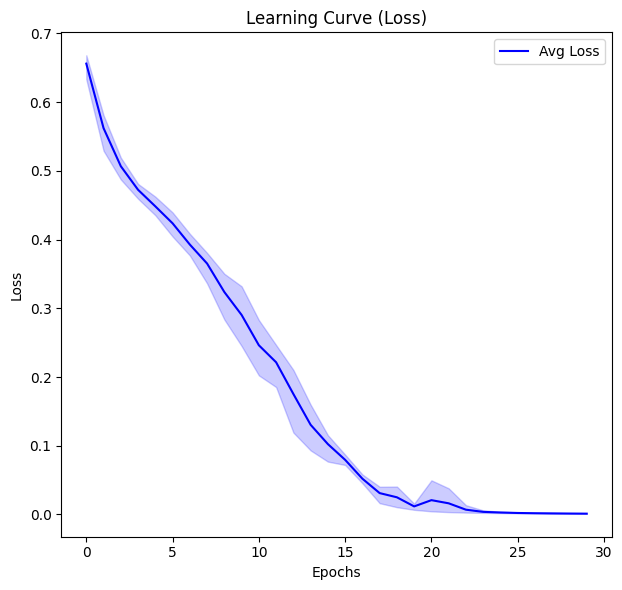

Accuracy on test: 0.5175, f1-score on test: 0.3654



In [70]:
baseline_trainer = CustomTrainer(model=baseline_model, num_epochs=30, batch_size=32, learning_rate=0.001)

baseline_trainer.train_and_evaluate_multiple_seeds(train_df_embedded, validation_df_embedded, num_seeds=3)

accuracy, f1 = baseline_trainer.test(test_df_embedded)
print(f"Accuracy on test: {accuracy:.4f}, f1-score on test: {f1:.4f}", end="\n\n")

Using device: cuda

### Start training and testing with 3 seeds ###


Training with seed 0: 100%|██████████| 30/30 [00:19<00:00,  1.56it/s]


Accuracy on val: 0.7848, f1-score on val: 0.7716



Training with seed 1: 100%|██████████| 30/30 [00:12<00:00,  2.41it/s]


Accuracy on val: 0.7848, f1-score on val: 0.7684



Training with seed 2: 100%|██████████| 30/30 [00:14<00:00,  2.07it/s]


Accuracy on val: 0.7975, f1-score on val: 0.7836



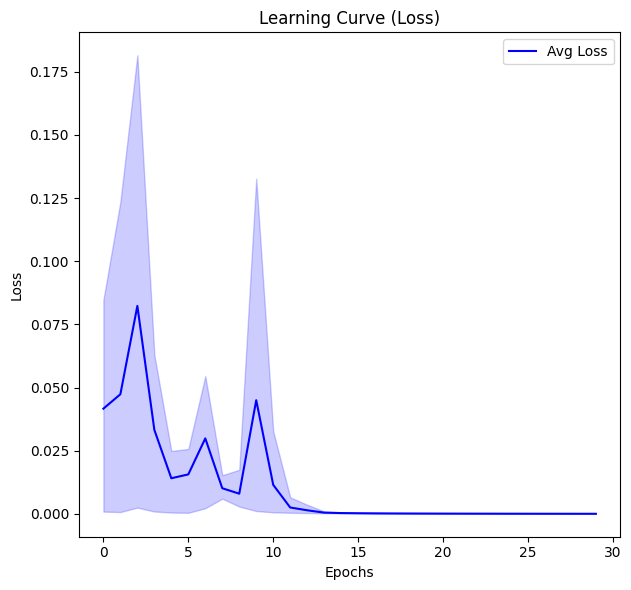

Accuracy on test: 0.7727, f1-score on test: 0.7653



In [74]:
model_1_trainer = CustomTrainer(model=model_1, num_epochs=30, batch_size=32, learning_rate=0.001)

model_1_trainer.train_and_evaluate_multiple_seeds(train_df_embedded, validation_df_embedded, num_seeds=3)
accuracy, f1 = model_1_trainer.test(test_df_embedded)
print(f"Accuracy on test: {accuracy:.4f}, f1-score on test: {f1:.4f}", end="\n\n")

In [19]:
print(train_df_embedded['tweet'].iloc[0])
print(train_df_embedded['tweet'].iloc[1])
print(train_df_embedded['tweet'].iloc[4])
print(nn.Sigmoid()(baseline_model(torch.tensor(train_df_embedded['padded_tweet'].iloc[:5], dtype=torch.float32).to("cuda"))))
print(nn.Sigmoid()(model_1(torch.tensor(train_df_embedded['padded_tweet'].iloc[:5], dtype=torch.float32).to("cuda"))))

writing uni essay local pub coffee random old man keep asking drunk question im trying concentrate amp end good luck youll end getting married use anyway alive well
2021 1921 dont appreciate two ride team member looked behind asked man behind many party impressed
new shelf week looking forward reading book
tensor([0.5020, 0.4784, 0.4953, 0.5031, 0.5056], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
tensor([0.5051, 0.5080, 0.5097, 0.5076, 0.5101], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


# [Task 6 - 1.0 points] Transformers

In this section, you will use a transformer model specifically trained for hate speech detection, namely [Twitter-roBERTa-base for Hate Speech Detection](https://huggingface.co/cardiffnlp/twitter-roberta-base-hate).




### Relevant Material
- Tutorial 3

### Instructions
1. **Load the Tokenizer and Model**

2. **Preprocess the Dataset**:
   You will need to preprocess your dataset to prepare it for input into the model. Tokenize your text data using the appropriate tokenizer and ensure it is formatted correctly.

   **Note**: You have to use the plain text of the dataset and not the version that you tokenized before, as you need to tokenize the cleaned text obtained after the initial cleaning process.

3. **Train the Model**:
   Use the `Trainer` to train the model on your training data.

4. **Evaluate the Model on the Test Set** using F1-macro.

In [20]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [21]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request
from datasets import Dataset
from transformers import TrainingArguments
from transformers import DataCollatorWithPadding
from transformers import Trainer
from sklearn.metrics import f1_score, accuracy_score

In [22]:
train_df = original_train_df.copy()
validation_df = original_validation_df.copy()
test_df = original_test_df.copy()

In [23]:
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

train_df['tweet'] = train_df['tweet'].apply(preprocess)
train_df.head()

,id_EXIST,lang,tweet,hard_label_task1
200002,200002,en,Writing a uni essay in my local pub with a cof...,1
200003,200003,en,@user it is 2021 not 1921. I dont appreciate t...,1
200006,200006,en,According to a customer I have plenty of time ...,1
200007,200007,en,"So only 'blokes' drink beer? Sorry, but if you...",1
200008,200008,en,New to the shelves this week - looking forward...,0


In [24]:
task='hate'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [25]:
def preprocess_text(texts):
    return tokenizer(texts['tweet'], truncation=True)

train_data = Dataset.from_pandas(train_df)
test_data = Dataset.from_pandas(test_df)

train_data = train_data.map(preprocess_text, batched=True)
test_data = test_data.map(preprocess_text, batched=True)
train_data

Map:   0%|          | 0/2870 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/286 [00:00<?, ? examples/s]

Dataset({
    features: ['id_EXIST', 'lang', 'tweet', 'hard_label_task1', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 2870
})

In [26]:
train_data = train_data.rename_column('hard_label_task1', 'label')
test_data = test_data.rename_column('hard_label_task1', 'label')

In [27]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [39]:
training_args = TrainingArguments(
    output_dir="test_dir",                 # where to save model
    learning_rate=2e-5,
    per_device_train_batch_size=8,         # accelerate defines distributed training
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    evaluation_strategy="epoch",           # when to report evaluation metrics/losses
    save_strategy="epoch",                 # when to save checkpoint
    load_best_model_at_end=True,
    report_to='none'                       # disabling wandb (default)
)

In [29]:
def compute_metrics(output_info):
    predictions, labels = output_info
    predictions = np.argmax(predictions, axis=-1)

    f1 = f1_score(y_pred=predictions, y_true=labels, average='macro')
    acc = accuracy_score(y_pred=predictions, y_true=labels)
    return {'f1': f1, 'acc': acc}

In [40]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [41]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1,Acc
1,No log,0.498139,0.812450,0.818182
2,0.301300,0.778808,0.822033,0.825175
3,0.174000,1.016115,0.819272,0.821678
4,0.174000,1.077748,0.845238,0.846154
5,0.077100,1.226609,0.839018,0.842657
6,0.033700,1.383845,0.820712,0.821678


KeyboardInterrupt: 

In [42]:
test_prediction_info = trainer.predict(test_data)
test_predictions, test_labels = test_prediction_info.predictions, test_prediction_info.label_ids

print(test_predictions.shape)
print(test_labels.shape)

Epoch,Training Loss,Validation Loss,F1,Acc
1,No log,0.498139,0.812450,0.818182
2,0.301300,0.778808,0.822033,0.825175
3,0.174000,1.016115,0.819272,0.821678
4,0.174000,1.077748,0.845238,0.846154
5,0.077100,1.226609,0.839018,0.842657
6,0.033700,1.383845,0.820712,0.821678


(286, 2)
(286,)


In [43]:
test_metrics = compute_metrics([test_predictions, test_labels])
print(test_metrics)

{'f1': 0.8168923910366905, 'acc': 0.8181818181818182}


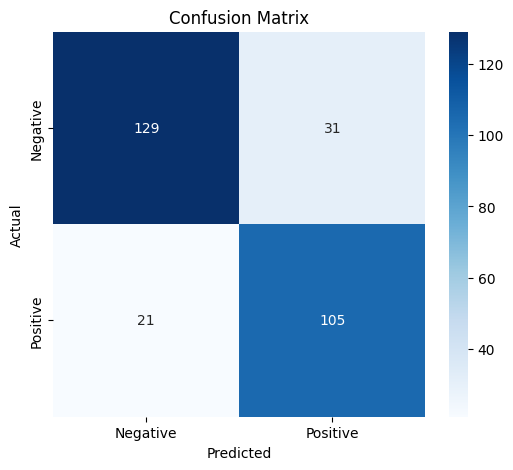

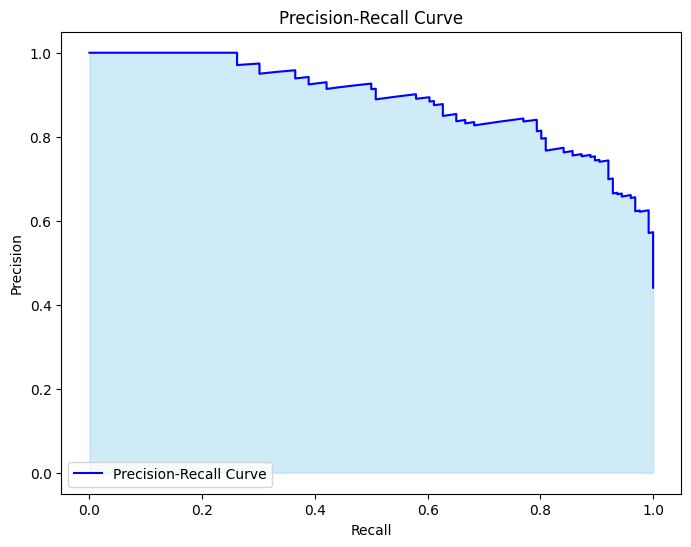

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.81      0.83       160
           1       0.77      0.83      0.80       126

    accuracy                           0.82       286
   macro avg       0.82      0.82      0.82       286
weighted avg       0.82      0.82      0.82       286



In [44]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, PrecisionRecallDisplay
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import seaborn as sns


def show_conf_matrix(y_test, y_prob):
    y_pred = np.argmax(y_prob, axis=-1)

    conf_matrix = confusion_matrix(y_test, y_pred)

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    precision, recall, thresholds = precision_recall_curve(y_test, y_prob[:, 1])

    # Plot Precision-Recall curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color="b", label="Precision-Recall Curve")
    plt.fill_between(recall, precision, color="skyblue", alpha=0.4)
    plt.title("Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc="lower left")
    plt.show()

    print("Classification Report:")
    print(classification_report(y_test, y_pred))

show_conf_matrix(test_labels, test_predictions)

In [45]:
def analyze_errors(text, pred, label, tokenizer):
    # Check if pred and label are of the same length
    if len(pred) != len(label):
        raise ValueError("The length of prediction and label lists must be the same.")

    # Initialize a list to store the results of incorrect predictions
    incorrect_preds = []

    pred = np.argmax(pred, axis=-1)
    # Iterate through each token in the prediction and label
    for i in range(len(pred)):
        # If the prediction is incorrect, we'll process this token
        if pred[i] != label[i]:
            incorrect_preds.append((text[i], i))

    print(f"Number of incorrect prediction: {len(incorrect_preds)}")
    print("First dot reprsent label, second represent prediction, red means sexist")
    # If there are incorrect predictions, print them and color OOV tokens
    for err, idx in incorrect_preds:
        if label[idx] == 1:
            print("🔴", end=" ")
        else:
            print("🟢", end=" ")
        if pred[idx] == 1:
            print("🔴", end=" ")
        else:
            print("🟢", end=" ")
        print(err)

analyze_errors(test_data['tweet'], test_predictions, test_labels, tokenizer)

Number of incorrect prediction: 52
First dot reprsent label, second represent prediction, red means sexist
🟢 🔴 “I mean I do, but… wouldn’t it be fun to get gangbanged together~?” https://t.co/lNRZ9z53VL
🟢 🔴 @LogicalFallac18 @LBC Sex* as in 'gender' harassment is what they are inferring.
🟢 🔴 Appreciate being included along with @wphillips49 on the Uvalde gunman’s history of cyber gender harassment. Regrettably unshocking. @UVALaw https://t.co/gg1UwHYdIf
🟢 🔴 @EyemotionFandom How did we reach a point where blonks are having the audacity to talk about yoongis rap do y'all see who you Stan ? Are y'all ok ?? Your girls can't write can't deliver can't come close to bts's lyricism tf are y'all getting brave for ?? Fashion deals ??
🟢 🔴 He Tries To Expose This Gold Digger BUT IT BACKFIRES. | 90 Day Fiancée B... https://t.co/pz91AbJ0WS via @YouTube
🟢 🔴 @MatrixPirate12 Well let me ask for the guys… do you ever just grab your testicles because you can?
🔴 🟢 @DaddyBrianMC @roadhouse2100 @stlcty03 Not

# COSE DA FARE

 ### ERROR ANALYSIS
 FAQ: <br>
 Some topics for discussion include:
   * Precision/Recall curves.
   * Confusion matrices.
   * Specific misclassified samples.

NOSTRE: <br>
 * Nelle frasi sbagliate, printare la frase con i token che non sono nel vocabolario colorati di rosso.
 * Controllo delle distribuzioni del dataset (bilanciato?)
 * Discutere gli errori comuni e le performance


 ### IDEE EXTRA
  * Usare embedding trainabili invece di globe
  * Mantenere le emojy e hashtag nel testo dei tweet
  * Usare tokenizer nel primo task


# [Task 7 - 0.5 points] Error Analysis

### Instructions

After evaluating the model, perform a brief error analysis:

 - Review the results and identify common errors.

 - Summarize your findings regarding the errors and their impact on performance (e.g. but not limited to Out-of-Vocabulary (OOV) words, data imbalance, and performance differences between the custom model and the transformer...)
 - Suggest possible solutions to address the identified errors.



#### Start with an analysis of the dataset to see the data

In [46]:
train_df.hist

,id_EXIST,lang,tweet,hard_label_task1
200002,200002,en,Writing a uni essay in my local pub with a cof...,1
200003,200003,en,@user it is 2021 not 1921. I dont appreciate t...,1
200006,200006,en,According to a customer I have plenty of time ...,1
200007,200007,en,"So only 'blokes' drink beer? Sorry, but if you...",1
200008,200008,en,New to the shelves this week - looking forward...,0
...,...,...,...,...
203256,203256,en,idk why y’all bitches think having half your a...,1
203257,203257,en,This has been a part of an experiment with @us...,1
203258,203258,en,"""Take me already"" ""Not yet. You gotta be ready...",1
203259,203259,en,@user why do you look like a whore? /lh http,1


In [ ]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

# Download NLTK stopwords
nltk.download('stopwords')
nltk.download('punkt')

FARE LA CELLA SUCCESSSIVA PER TUTTI E 3 I DATASET


Label Distribution
label
0    1733
1    1137
Name: count, dtype: int64


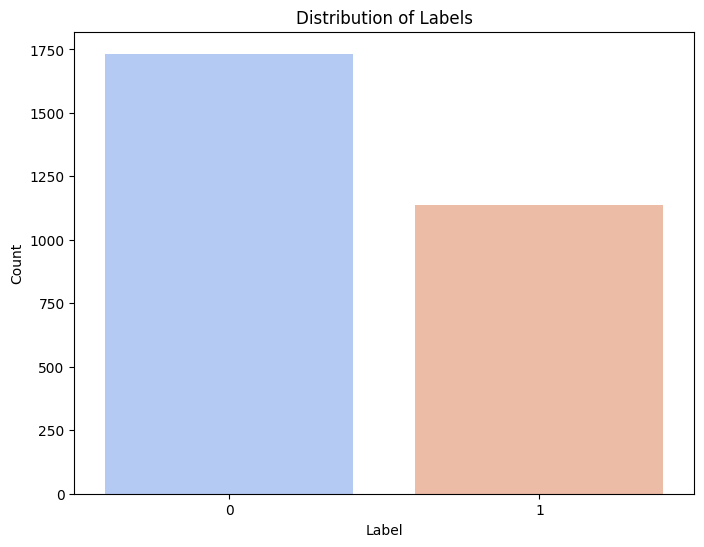

In [63]:
data = train_df
data_val = validation_df
data_test = test_df
# Load the dataset (replace 'your_dataset.csv' with the actual file name)
# The dataset should have at least two columns: 'tweet' and 'label'
data = data.rename(columns={'hard_label_task1': 'label'})
data_val = data_val.rename(columns={'hard_label_task1': 'label'})
data_test = data_test.rename(columns={'hard_label_task1': 'label'})


# Ensure the dataset has the required columns
assert 'tweet' in data.columns and 'label' in data.columns, "Dataset must have 'tweet' and 'label' columns"

# Basic Statistics
print("\nLabel Distribution")
print(data['label'].value_counts())

# 1. Label Distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='label', palette='coolwarm')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

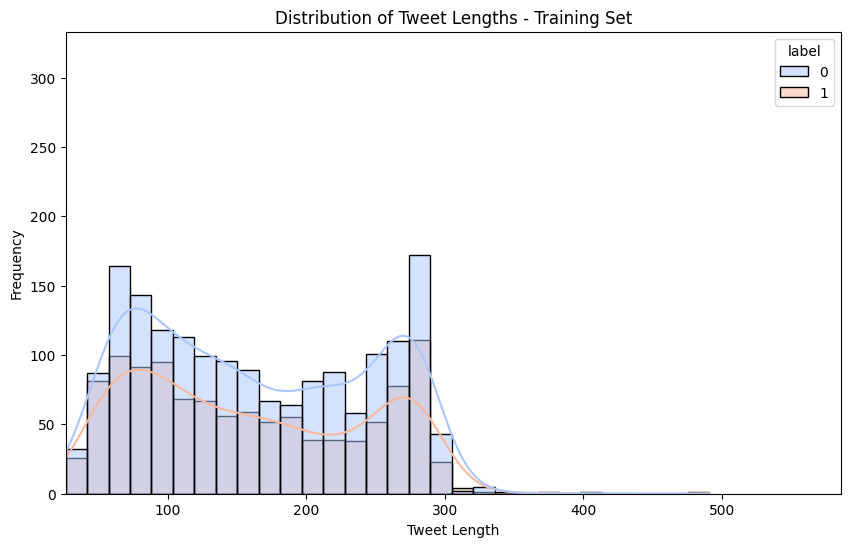

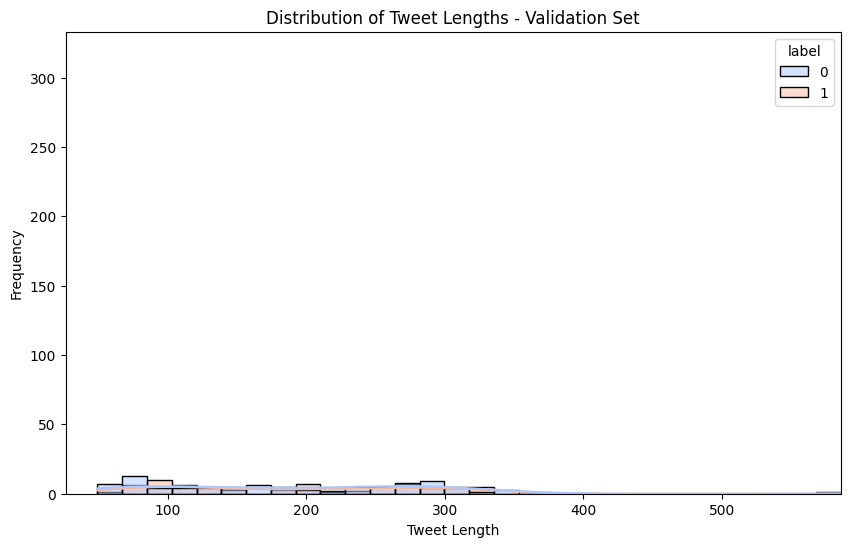

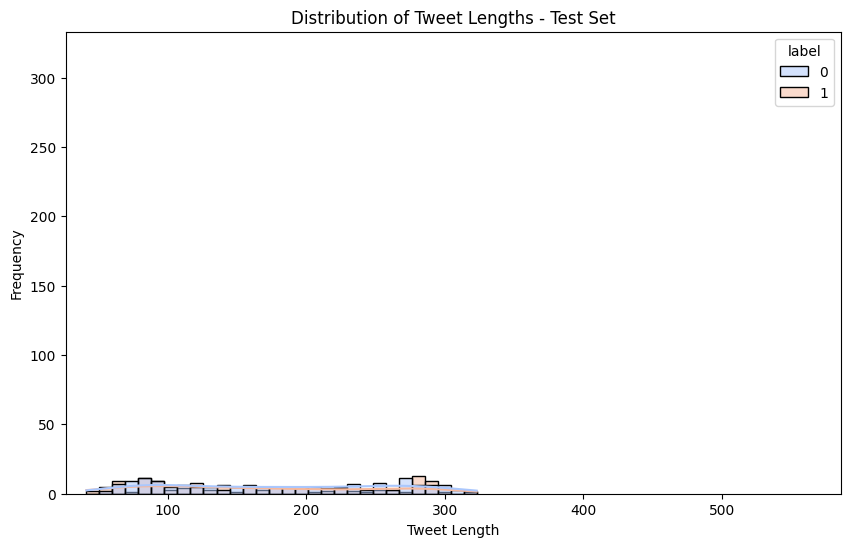

In [67]:
# 2. Text Length Analysis
def plot_distr_tweet_len(data_list, labels):
    """
    Plots the distribution of tweet lengths for multiple datasets with consistent x and y axis ranges.

    Parameters:
        data_list (list of pd.DataFrame): List of datasets to plot.
        labels (list of str): List of labels for the datasets (used for plot titles).
    """
    # Calculate tweet lengths for all datasets
    for data in data_list:
        data['tweet_length'] = data['tweet'].apply(len)

    # Determine global x and y axis limits
    all_lengths = pd.concat([data['tweet_length'] for data in data_list])
    x_min, x_max = all_lengths.min(), all_lengths.max()

    max_y = 0
    for data in data_list:
        _, bins = np.histogram(data['tweet_length'], bins=30, range=(x_min, x_max))
        max_y = max(max_y, np.histogram(data['tweet_length'], bins=bins)[0].max())

    # Plot each dataset with consistent axes
    for i, data in enumerate(data_list):
        plt.figure(figsize=(10, 6))
        sns.histplot(data, x='tweet_length', hue='label', bins=30, kde=True, palette='coolwarm')
        plt.title(f'Distribution of Tweet Lengths - {labels[i]}')
        plt.xlabel('Tweet Length')
        plt.ylabel('Frequency')
        plt.xlim(x_min, x_max)
        plt.ylim(0, max_y + 5)  # Add a small margin for clarity
        plt.show()

# Example Usage
plot_distr_tweet_len([data, data_val, data_test], labels=['Training Set', 'Validation Set', 'Test Set'])


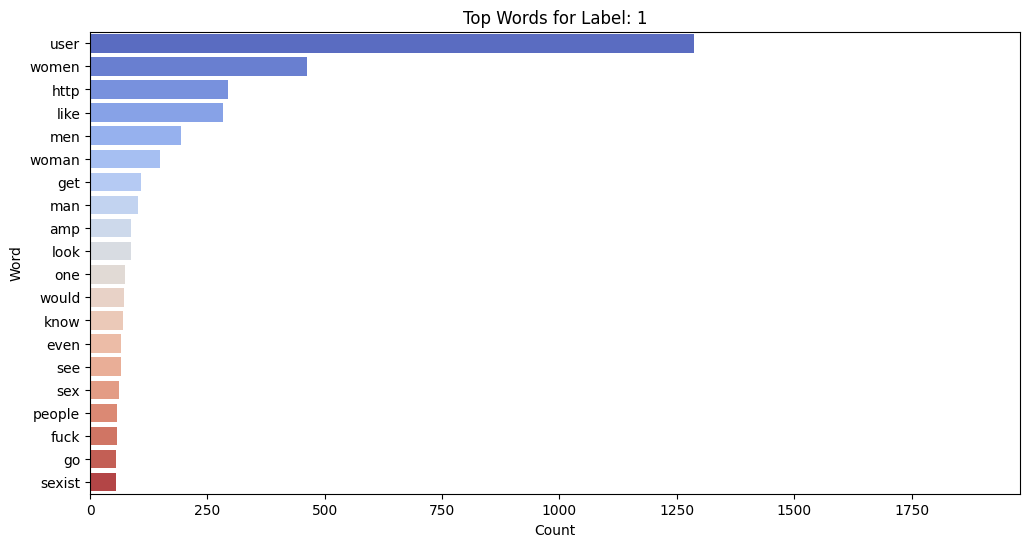

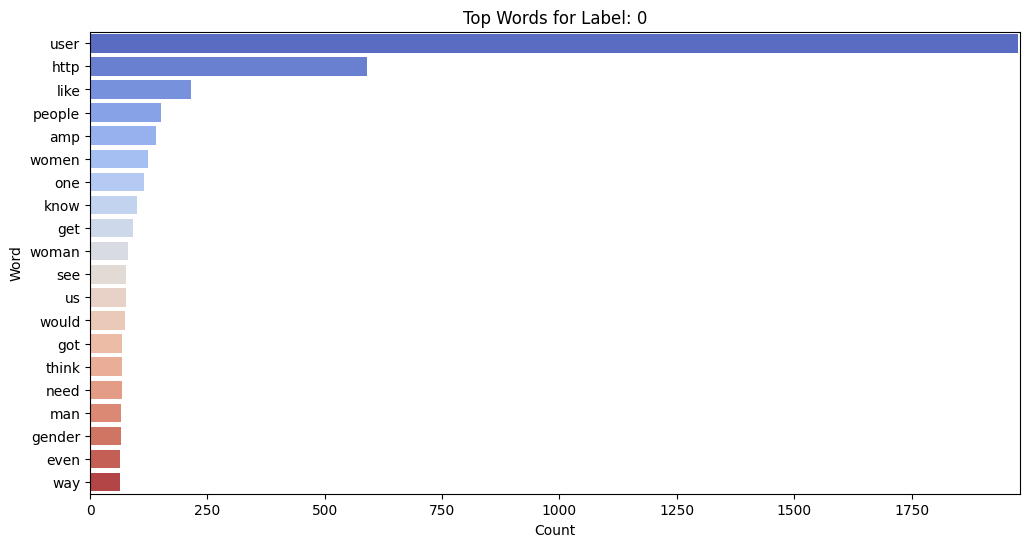

In [61]:
# 6. Common Words (Bar Plot with Consistent X-axis Range)
from collections import Counter

# Function to preprocess the text
stop_words = set(stopwords.words('english') + list(string.punctuation))

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    filtered_words = [word for word in tokens if word not in stop_words and word.isalnum()]
    return ' '.join(filtered_words)

data['cleaned_tweet'] = data['tweet'].apply(preprocess_text)

# Function to find top words for a specific label
def get_top_words(texts, n=20):
    all_words = ' '.join(texts).split()
    most_common = Counter(all_words).most_common(n)
    return pd.DataFrame(most_common, columns=['word', 'count'])

# Find the maximum count across all labels for consistent x-axis range
max_count = 0
label_top_words = {}
for label in data['label'].unique():
    subset = data[data['label'] == label]
    top_words = get_top_words(subset['cleaned_tweet'])
    label_top_words[label] = top_words
    if not top_words.empty:
        max_count = max(max_count, top_words['count'].max())

# Plotting top words with consistent x-axis range
for label, top_words in label_top_words.items():
    if not top_words.empty:
        plt.figure(figsize=(12, 6))
        sns.barplot(data=top_words, x='count', y='word', palette='coolwarm')
        plt.title(f"Top Words for Label: {label}")
        plt.xlabel('Count')
        plt.ylabel('Word')
        plt.xlim(0, max_count + 5)  # Adding a small margin for better visuals
        plt.show()


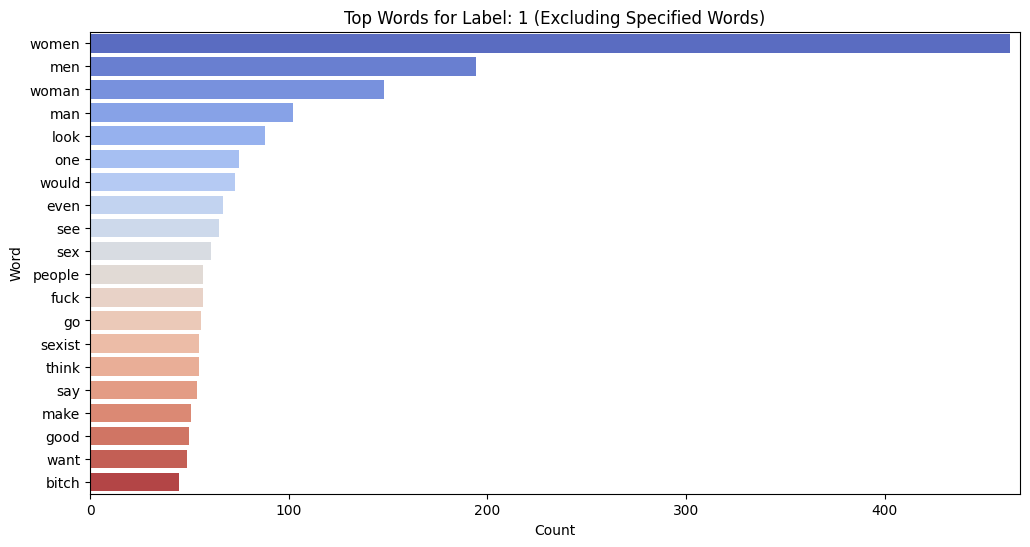

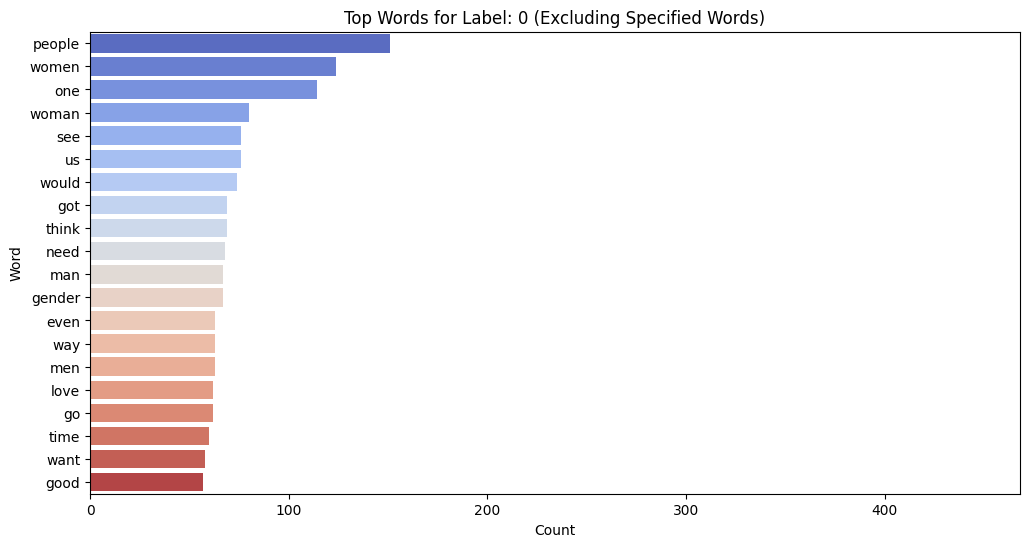

In [60]:
# 6. Common Words (Excluding Specific Words) - Bar Plot with Consistent X-axis Range
from collections import Counter

# List of words to exclude (add your own words here)
exclude_words = {'user', 'http', 'amp', 'like', 'get', 'know'}  # Replace with the words you want to exclude

# Function to preprocess the text
stop_words = set(stopwords.words('english') + list(string.punctuation) + list(exclude_words))

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    filtered_words = [word for word in tokens if word not in stop_words and word.isalnum()]
    return ' '.join(filtered_words)

data['cleaned_tweet'] = data['tweet'].apply(preprocess_text)

# Function to find top words for a specific label
def get_top_words(texts, n=20):
    all_words = ' '.join(texts).split()
    most_common = Counter(all_words).most_common(n)
    return pd.DataFrame(most_common, columns=['word', 'count'])

# Find the maximum count across all labels for consistent x-axis range
max_count = 0
label_top_words = {}
for label in data['label'].unique():
    subset = data[data['label'] == label]
    top_words = get_top_words(subset['cleaned_tweet'])

    # Exclude words in the exclude_words list
    top_words = top_words[~top_words['word'].isin(exclude_words)]
    label_top_words[label] = top_words
    if not top_words.empty:
        max_count = max(max_count, top_words['count'].max())

# Plotting top words with consistent x-axis range
for label, top_words in label_top_words.items():
    if not top_words.empty:
        plt.figure(figsize=(12, 6))
        sns.barplot(data=top_words, x='count', y='word', palette='coolwarm')
        plt.title(f"Top Words for Label: {label} (Excluding Specified Words)")
        plt.xlabel('Count')
        plt.ylabel('Word')
        plt.xlim(0, max_count + 5)  # Adding a small margin for better visuals
        plt.show()


# [Task 8 - 0.5 points] Report

Wrap up your experiment in a short report (up to 2 pages).

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is not a copy-paste of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.


# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...
* You can upload **model weights** in a cloud repository and report the link in the report.

# FAQ

Please check this frequently asked questions before contacting us

### Execution Order

You are **free** to address tasks in any order (if multiple orderings are available).

### Trainable Embeddings

You are **free** to define a trainable or non-trainable Embedding layer to load the GloVe embeddings.

### Model architecture

You **should not** change the architecture of a model (i.e., its layers).
However, you are **free** to play with their hyper-parameters.


### Neural Libraries

You are **free** to use any library of your choice to implement the networks (e.g., Keras, Tensorflow, PyTorch, JAX, etc...)

### Keras TimeDistributed Dense layer

If you are using Keras, we recommend wrapping the final Dense layer with `TimeDistributed`.

### Robust Evaluation

Each model is trained with at least 3 random seeds.

Task 4 requires you to compute the average performance over the 3 seeds and its corresponding standard deviation.

### Model Selection for Analysis

To carry out the error analysis you are **free** to either

* Pick examples or perform comparisons with an individual seed run model (e.g., Baseline seed 1337)
* Perform ensembling via, for instance, majority voting to obtain a single model.

### Error Analysis

Some topics for discussion include:
   * Precision/Recall curves.
   * Confusion matrices.
   * Specific misclassified samples.

### Bonus Points
Bonus points are arbitrarily assigned based on significant contributions such as:
- Outstanding error analysis
- Masterclass code organization
- Suitable extensions
Note that bonus points are only assigned if all task points are attributed (i.e., 6/6).

**Possible Extensions/Explorations for Bonus Points:**
- **Try other preprocessing strategies**: e.g., but not limited to, explore techniques tailored specifically for tweets or  methods that are common in social media text.
- **Experiment with other custom architectures or models from HuggingFace**
- **Explore Spanish tweets**: e.g., but not limited to, leverage multilingual models to process Spanish tweets and assess their performance compared to monolingual models.







# The End